In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, r'..\tools')
from rename_file import rename_file
from scan import scan_file
from smooth import smooth
from color_convert import color_convert_plt

[]


<center>对一个文件夹里面的所有文件名前缀进行修改，添加的前缀为二级文件夹名字</center>

In [2]:
def scan_file(path: Path, file_info: list):
    # extensions = ['xml', 'png', 'jpg']
    extensions = ['txt']
    for f in path.iterdir():
        if f.is_file() and f.suffix[1:] in extensions:   ###f.suffix显示f的后缀
            file_info.append([f.name, f.suffix[1:], str(path)])
        elif f.is_dir() and str(f)[-12:]!='non_pv_homer':   ###把结尾为in wake的文件夹排除在外
            scan_file(f, file_info)

    return file_info

<center>刺激后从REM到另外两个状态的delay</center>


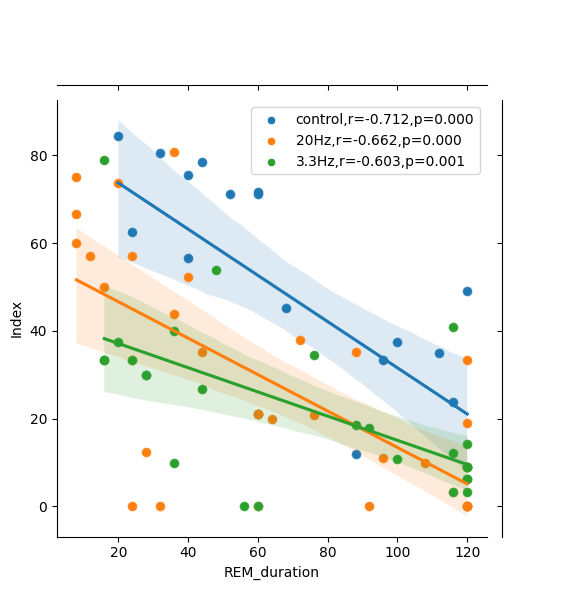

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sci

# 示例数据
path=r'.\stimulation_in_rem\time_dependent_change'
data1 = pd.read_csv(path+'\\REM-latency_control.csv')
# data1=data1[data1['REM_duration'] != 120]
data2 = pd.read_csv(path+'\\REM-latency_20Hz.csv')
# data2=data1[data2['REM_duration'] != 120]
data3 = pd.read_csv(path+'\\REM-latency_3.3Hz.csv')
# data3=data3[data3['REM_duration'] != 120]

# 创建 JointGrid 对象

g = sns.JointGrid(x=data1.REM_duration, y=data1.Index, data=data1)
r1,p1=sci.pearsonr(data1.REM_duration,data1.Index)
# 在 JointGrid 上绘制分布图和线性回归线
g.plot_joint(sns.scatterplot,label=f"control,{'r=%.3f,p=%.3f'%(r1,p1)}")
# g.plot_marginals(sns.histplot, kde=True)
g.plot_joint(sns.regplot)

# 更新 JointGrid 对象以绘制第二组数据
g.x = data2.REM_duration
g.y = data2.Index
r2,p2=sci.pearsonr(data2.REM_duration,data2.Index)
g.plot_joint(sns.scatterplot,label=f"20Hz,{'r=%.3f,p=%.3f'%(r2,p2)}")
# g.plot_marginals(sns.histplot, kde=True)
g.plot_joint(sns.regplot,)

# 更新 JointGrid 对象以绘制第二组数据
g.x = data3.REM_duration
g.y = data3.Index
r3,p3=sci.pearsonr(data3.REM_duration,data3.Index)
g.plot_joint(sns.scatterplot,label=f"3.3Hz,{'r=%.3f,p=%.3f'%(r3,p3)}")
# g.plot_marginals(sns.histplot, kde=True)
g.plot_joint(sns.regplot)

plt.savefig(path+'\\latency_reg_Index.pdf')
# 显示图形
plt.show()

['REM-latency_20Hz.csv', 'REM-latency_3.3Hz.csv', 'REM-latency_control.csv']
20Hz average em frequency  duration: 8.209723079287805, latency: 20
3.3Hz average em frequency  duration: 6.297234313533595, latency: 3.3
control average em frequency  duration: 8.770266979470833, latency: 1.83


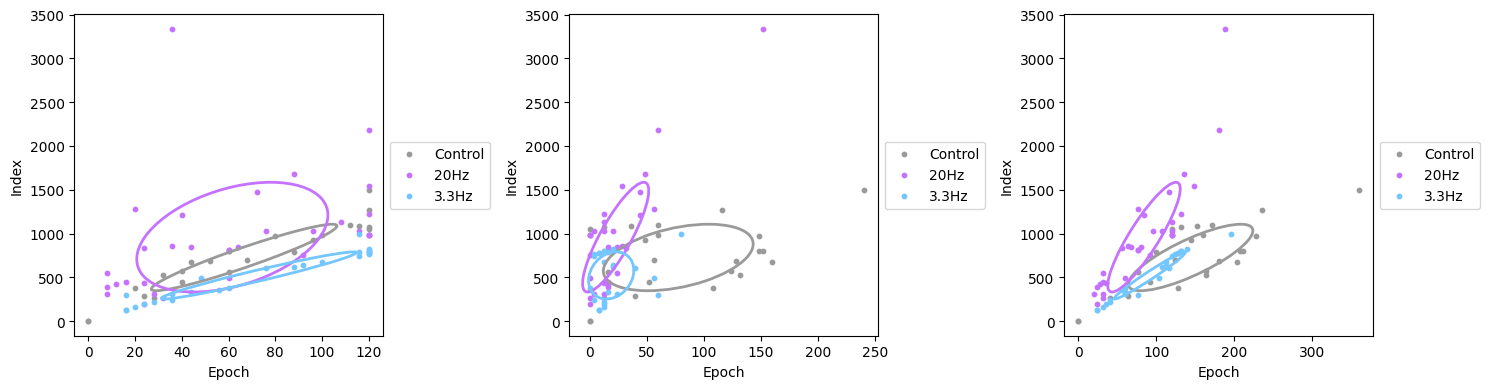

In [4]:
import os
import pandas as pd
from matplotlib.patches import Ellipse

# 绘制椭圆
def plot_ellipse(mean, cov, color):
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    max_variance_index = np.argmax(eigenvalues)
    max_eigenvector = eigenvectors[:, max_variance_index]
    angle = np.degrees(np.arctan2(max_eigenvector[1], max_eigenvector[0]))
    ellipse = Ellipse(xy=mean,
                      width=2 * np.sqrt(eigenvalues[max_variance_index]),
                      height=2 * np.sqrt(eigenvalues[1 - max_variance_index]),
                      angle=angle,
                      edgecolor=color,
                      facecolor='None',
                      linewidth=2)
    plt.gca().add_patch(ellipse)


path=r'.\stimulation_in_rem\EM_duration_latency_relationship'
file=[i for i in os.listdir(path) if i.endswith('.csv')]
print(file)
arr={k[:-4]:[] for k in file}

em_fre={'20Hz':4.59,'3.3Hz':16.4,'control':1.83}
em_fre={'20Hz':20,'3.3Hz':3.3,'control':1.83}
for file_i in file:
    df=pd.read_csv(path+'\\'+file_i)

    group_name=[i for i in em_fre.keys() if  i in str(file_i)]

    em_duration=np.mean(df.emFre_duration)
    # em_latency=np.mean(df.emFre_latency)
    em_latency=em_fre[group_name[0]]
    print(f'{file_i[12:-4]} average em frequency  duration: {em_duration}, latency: {em_latency}')
    Integral1=df.REM_duration
    Integral2=df.REM_latency
    Integral3=df.REM_duration+df.REM_latency

    ###每个trial单独计算平均眼动
    # Integral4=df.REM_duration*df.emFre_duration+df.REM_latency*df.emFre_latency
    ###所有trials计算平均眼动
    Integral4=df.REM_duration*em_duration+df.REM_latency*em_latency

    # print(Integral4)

    arr[file_i[:-4]]=[Integral1,Integral2,Integral3,Integral4]

fig = plt.figure(figsize=(15,4))

for i in range(3):
    ax1 = fig.add_subplot(1, 3, i+1)
    control_x=arr['REM-latency_control'][i]

    control_y=arr['REM-latency_control'][3]

    HighFre_x=arr['REM-latency_20Hz'][i]
    HighFre_y=arr['REM-latency_20Hz'][3]

    LowFre_x=arr['REM-latency_3.3Hz'][i]
    LowFre_y=arr['REM-latency_3.3Hz'][3]

    ax1.scatter(control_x, control_y,s=10, c=[color_convert_plt('#9a9a9a')], label='Control')
    ax1.scatter(HighFre_x, HighFre_y,s=10, c=[color_convert_plt('#c572ff')], label='20Hz')
    ax1.scatter(LowFre_x, LowFre_y,s=10, c=[color_convert_plt('#74c6fe')], label='3.3Hz')
    plt.xlabel('Epoch');plt.ylabel('Index')
    plt.legend(loc='center left',  bbox_to_anchor=(1, 0.5),prop={'size':10})

    # 计算各组数据的均值和协方差
    control_mean = [np.mean(control_x), np.mean(control_y)]
    HighFre_mean = [np.mean(HighFre_x), np.mean(HighFre_y)]
    LowFre_mean = [np.mean(LowFre_x), np.mean(LowFre_y)]

    control_cov = np.cov(control_x, control_y)
    HighFre_cov = np.cov(HighFre_x, HighFre_y)
    LowFre_cov = np.cov(LowFre_x, LowFre_y)

    ###画出散点图的均值中心化协方差，圆形投影到具有最大方差的两个轴上
    plot_ellipse(control_mean, control_cov, color=color_convert_plt('#9a9a9a'))
    plot_ellipse(HighFre_mean, HighFre_cov, color=color_convert_plt('#c572ff'))
    plot_ellipse(LowFre_mean, LowFre_cov, color=color_convert_plt('#74c6fe'))
    # break
plt.savefig(path+'\\Index_Epoch(所有trials计算平均眼动)_直接乘光刺激频率.pdf')
# 显示图形
plt.tight_layout()
plt.show()


3.3Hz
(9, 91)
20Hz
(8, 91)
control
(8, 91)
NR刺激前后probability:{'before': [0.36362987170176714, 0.3454984388711169, 0.29795861613876323], 'after': [0.31576090750550734, 0.31987855156213235, 0.23381611472749245]}
R刺激前后probability:{'before': [0.5532276774547993, 0.567296736196108, 0.5887185996856031], 'after': [0.18777093231349704, 0.1553061073078566, 0.5434881364092496]}
W刺激前后probability:{'before': [0.041666666666666664, 0.05569444444444444, 0.07645833333333334], 'after': [0.4515123456790124, 0.47923611111111103, 0.18062500000000006]}


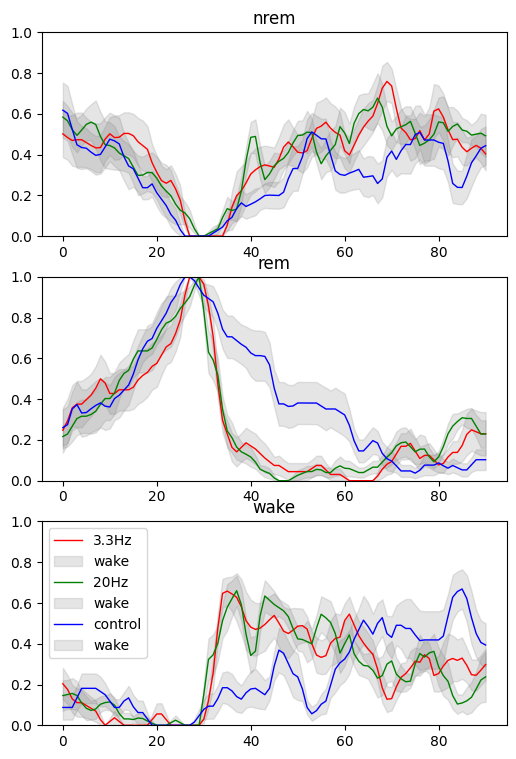

In [6]:
from scipy.interpolate import make_interp_spline
import math

root_dir=r'.\stimulation_in_rem\probability'
nrem=pd.read_excel(root_dir+'\\nrem_ratio.xlsx',sheet_name=None)
rem=pd.read_excel(root_dir+'\\rem_ratio.xlsx',sheet_name=None)
wake=pd.read_excel(root_dir+'\\wake_ratio.xlsx',sheet_name=None)

plt.figure(figsize=(6,9))
plt.subplot(311)
NR={'before':[],'after':[]}
for i,j in list(zip(nrem.keys(),'rgb')):
    print(i)
    nrem_data=nrem[i].iloc[:,1:]
    # nrem_data=nrem_data.apply(lambda x:ins_smooth(range(len(x)),x,900))
    nrem_data=nrem_data.apply(lambda x:smooth(x,2)).T
    print(nrem_data.shape)
    mean_nrem=np.mean(nrem_data,axis=0)
    sem_nrem=np.std(nrem_data)/(math.sqrt(nrem_data.shape[0]))

    plt.plot(mean_nrem,c=j,lw=1,label=i);plt.title('nrem');plt.ylim(0,1)
    plt.fill_between(range(len(sem_nrem)), mean_nrem - sem_nrem, mean_nrem + sem_nrem,
                     color='gray', alpha=0.2, label='wake')
    NR['before'].append(np.mean(mean_nrem[:int(len(mean_nrem)/3)]))
    NR['after'].append(np.mean(mean_nrem[int(len(mean_nrem)/3):int(len(mean_nrem)/3*2)]))
print(f'NR刺激前后probability:{NR}')


plt.subplot(312)
R={'before':[],'after':[]}
for i,j in list(zip(rem.keys(),'rgb')):
    rem_data=rem[i].iloc[:,1:]
    rem_data=rem_data.apply(lambda x:smooth(x,2)).T
    # print(nrem_data.shape[0])
    mean_rem=np.mean(rem_data,axis=0)
    sem_rem=np.std(rem_data)/(math.sqrt(rem_data.shape[0]))

    plt.plot(mean_rem,c=j,lw=1,label=i);plt.title('rem');plt.ylim(0,1)
    plt.fill_between(range(len(sem_rem)), mean_rem - sem_rem, mean_rem + sem_rem,
                     color='gray', alpha=0.2, label='wake')
    R['before'].append(np.mean(mean_rem[:int(len(mean_rem)/3)]))
    R['after'].append(np.mean(mean_rem[int(len(mean_rem)/3):int(len(mean_rem)/3*2)]))
print(f'R刺激前后probability:{R}')

plt.subplot(313)
W={'before':[],'after':[]}
for i,j in list(zip(wake.keys(),'rgb')):
    wake_data=wake[i].iloc[:,1:]
    wake_data=wake_data.apply(lambda x:smooth(x,2)).T
    # print(nrem_data.shape[0])
    mean_wake=np.mean(wake_data,axis=0)
    sem_wake=np.std(wake_data)/(math.sqrt(wake_data.shape[0]))

    plt.plot(mean_wake,c=j,lw=1,label=i);plt.title('wake');plt.ylim(0,1)
    plt.fill_between(range(len(sem_wake)), mean_wake - sem_wake, mean_wake + sem_wake,
                     color='gray', alpha=0.2, label='wake')
    W['before'].append(np.mean(mean_wake[:int(len(mean_wake)/3)]))
    W['after'].append(np.mean(mean_wake[int(len(mean_wake)/3):int(len(mean_wake)/3*2)]))
print(f'W刺激前后probability:{W}')
plt.savefig(root_dir+'\\stim_in_RemSleep.pdf')
plt.legend()
plt.show()